Цель проекта: приоритизировать гипотезы для увеличения выручки из списка, подготовленного отделом маркетинга. Запустить A/B-тест и проанализировать результаты. Имеющиеся данные:

Файл hypothesis.csv с девятью гипотезами по увеличению выручки интернет-магазина, содержит столбцы:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл orders.csv с заказами, содержит столбцы:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv с количеством посетителей из каждой группы за каждый день, содержит столбцы:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузка и подготовка данных

Подключаем библеотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Загружаем данные о количестве посетителей в каждый день, заказах и гипотезах из CSV-файлов в переменные.

In [2]:
try:
    data, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'), 
    pd.read_csv('/datasets/orders.csv'),  
    pd.read_csv('/datasets/visitors.csv')
)    
except:
    data, orders, visitors = (
    pd.read_csv('hypothesis.csv'), 
    pd.read_csv('orders.csv'), 
    pd.read_csv('visitors.csv')
)

Увеличиваем максимальную ширину ячеек для удобства просмотра, исправляем названия столбцов и типы данных в стобцах с датами.

In [3]:
pd.options.display.max_colwidth = 130
data.columns = data.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders['date'] = pd.to_datetime(orders['date']).dt.date 
visitors['date'] = pd.to_datetime(visitors['date']).dt.date 

Изучаем первые строки каждой из трех таблиц и информацию о таблицах в целом.

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [5]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проверяем таблицы на дубликаты.

In [7]:
print(orders[orders.duplicated(['transaction_id'])])
visitors.duplicated(['date', 'group']).sum()

Empty DataFrame
Columns: [transaction_id, visitor_id, date, revenue, group]
Index: []


0

Количество групп: 2
Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31
В группе А  503 , а в группе В  586  пользователей.
Число пользователей, оказавшихся в обеих группах: 58


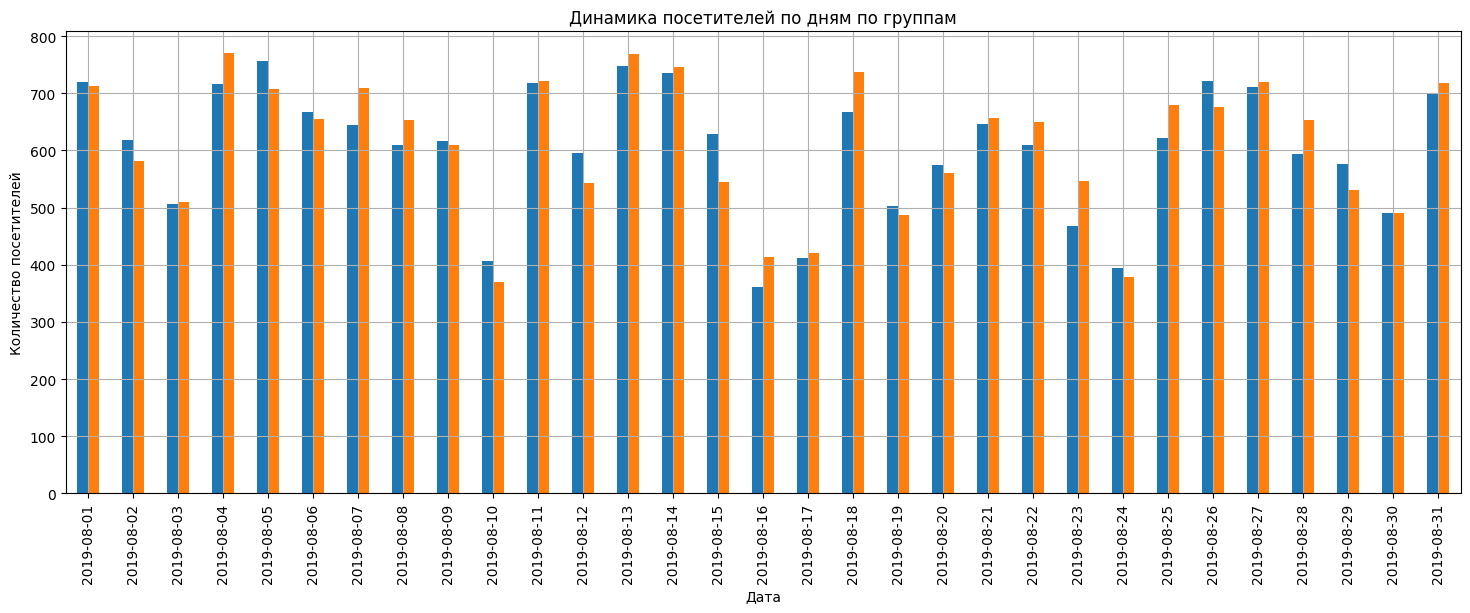

In [8]:
print(f'Количество групп: {orders["group"].nunique()}')

if orders["date"].min() == visitors["date"].min():
    print(f'Дата начала теста: {orders["date"].min()}')

if orders["date"].max() == visitors["date"].max():
    print(f'Дата окончания теста: {orders["date"].max()}')

print('В группе А ', orders.query('group=="A"')
      ['visitor_id'].nunique(), ', а в группе В ', 
      orders.query('group=="B"')['visitor_id'].nunique(), ' пользователей.')

groups_per_user = orders.groupby('visitor_id', as_index=False)['group'].nunique()
print(f'Число пользователей, оказавшихся в обеих группах: {groups_per_user.query("group==2")["visitor_id"].count()}')

visitors_per_day = visitors.pivot_table(index='date', columns='group', values='visitors')
visitors_per_day.plot(kind='bar', figsize=(18, 6), legend=False, grid=True)
plt.title('Динамика посетителей по дням по группам')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.show()

**Вывод:** *Методом Info() определили, что пропусков нет - количество значений в каждом из столбцов каждой таблицы соответствует числу строк таблицы. Типы данных корректные, дубликатов нет. Всего есть 2 группы, тест проходил в течение всего августа, число пользователей в группах немного отличается - в группе А - 503, а в группе В - 586 пользователей. Есть 58 пользователей, которые попали в обе группы.*

### Приоритизация гипотез

#### Применение фреймворка ICE для приоритизации гипотез

In [9]:
data['ICE'] = round(data['impact'] * data['confidence'] / data['efforts'], 2)
data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


*Индексы наиболее перспективных гипотез по способу приоритизации задач ICE: 8, 0, 7.*

#### Применение фреймворка RICE для приоритизации гипотез

In [10]:
data['RICE'] = data['impact'] * data['confidence'] * data['reach'] / data['efforts']
data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


*Индексы наиболее перспективных гипотез по методу RICE: 7, 2, 0.*

**Вывод:** *Топ наиболее приоритетных гипотез отличается в зависимости от выбора способа приоритизации. Это происходит потому, что метод RICE, в отличие от ICE, учитывает охват - количество пользователей, которых затронет вносимое изменение.* 

*Без учета параметра Reach, самая приоритетная - гипотеза "Запустить акцию, дающую скидку на товар в день рождения", гипотезы "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" находятся в середине топа перспективности.*

*С учетом Reach, топ самых перспективных гипотез:*

1. "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" 
2. "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
3. "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"

*Гипотеза с индексом 8 перестает быть приоритетной с учетом ее низкого охвата.*

### Анализ A/B-теста

#### Построение графика кумулятивной выручки по группам

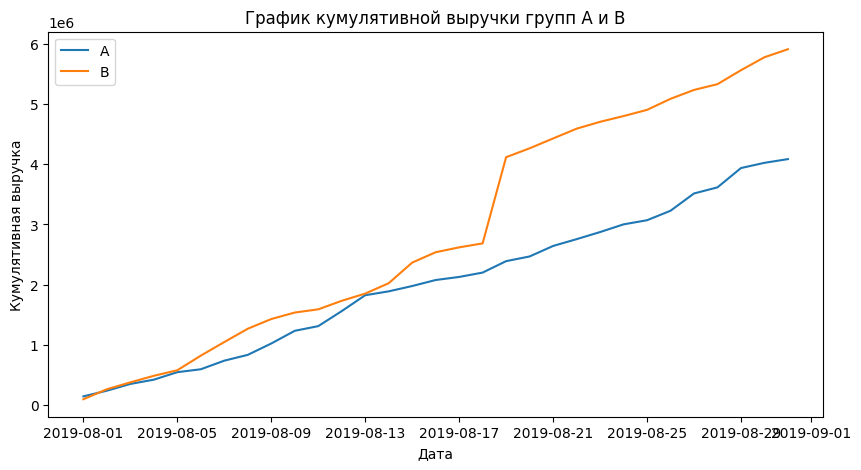

In [11]:
dates_groups = orders[['date', 'group']].drop_duplicates()

orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'count',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('График кумулятивной выручки групп A и B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.show()

*Кумулятивная выручка обеих групп возрастала равномерно, затем резко увеличилась для группы B с 18 по 19 августа, примерно с 2,5 до 4 миллионов, вероятно в результате заказа на крупную сумму либо резкого увеличения числа заказов.*

#### Построение графика кумулятивного среднего чека по группам

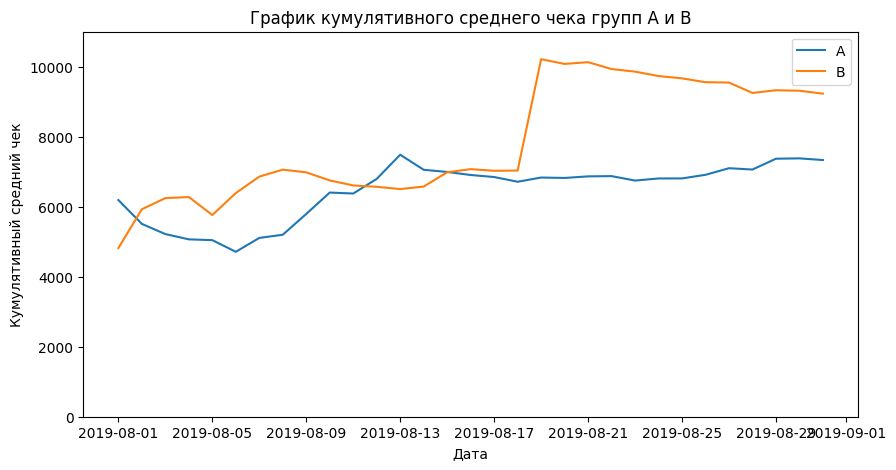

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека групп A и B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.ylim(0, 11000)
plt.show()

*Кумулятивное значение среднего чека по сегментам становится стабильнее к концу теста, но продолжает колебаться, принимать решение по этой метрике рано, группам нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. В группу B с 18 по 19 августа попали крупные заказы, что вызвало резкий всплеск на графике, средний чек группы B вырос до 10000 и с тех пор постепенно снижается.*

#### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

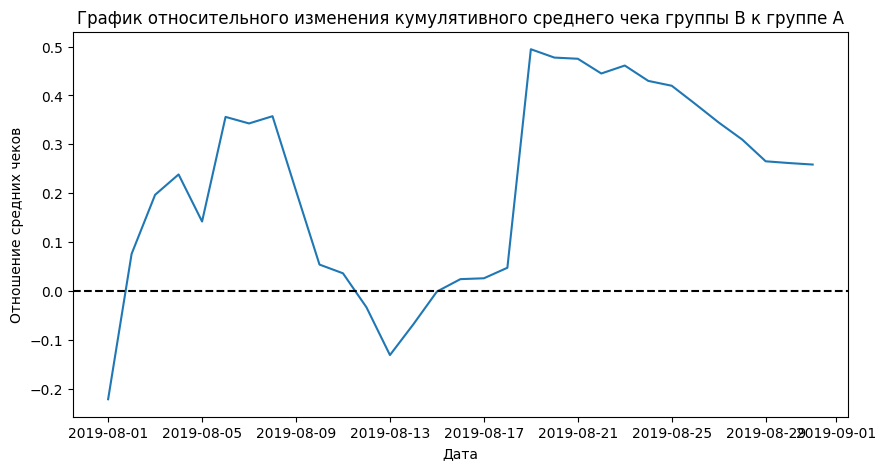

In [13]:
merged_сumulative_revenue = (
    cumulative_revenue_a
    .merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
)
plt.figure(figsize=(10, 5))
plt.plot(
    merged_сumulative_revenue['date'], 
         (merged_сumulative_revenue['revenue_b']/merged_сumulative_revenue['orders_b'])
         /(merged_сumulative_revenue['revenue_a']/merged_сumulative_revenue['orders_a'])-1
)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')
plt.show()

*График различия между сегментами резко скачет в несколько дат. Видимо, именно тогда были совершены аномальные заказы. На момент 19 августа средний чек группы B был выше среднего чека группы A на 50%, с тех пор различие постепенно снижается.*

#### Построение графика кумулятивного среднего количества заказов на посетителя по группам

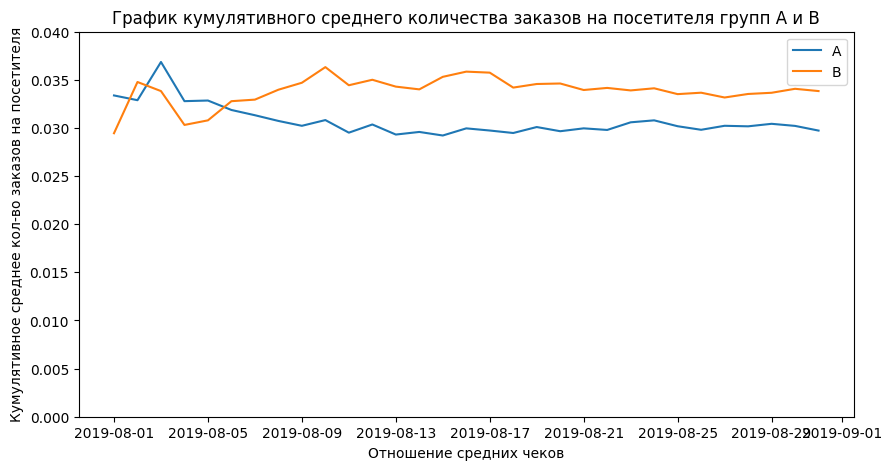

In [14]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(10, 5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.ylim(0, 0.04)
plt.title('График кумулятивного среднего количества заказов на посетителя групп А и B')
plt.ylabel('Кумулятивное среднее кол-во заказов на посетителя')
plt.xlabel('Отношение средних чеков')
plt.show()

*В начале теста группы колебались около одного значения, но постепенно сегмент B выровнялся и зафиксировался примерно около 0.035 заказа на одного посетителя, что больше этого значения у сегмента A - 0.03 заказа на посетителя.*

#### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

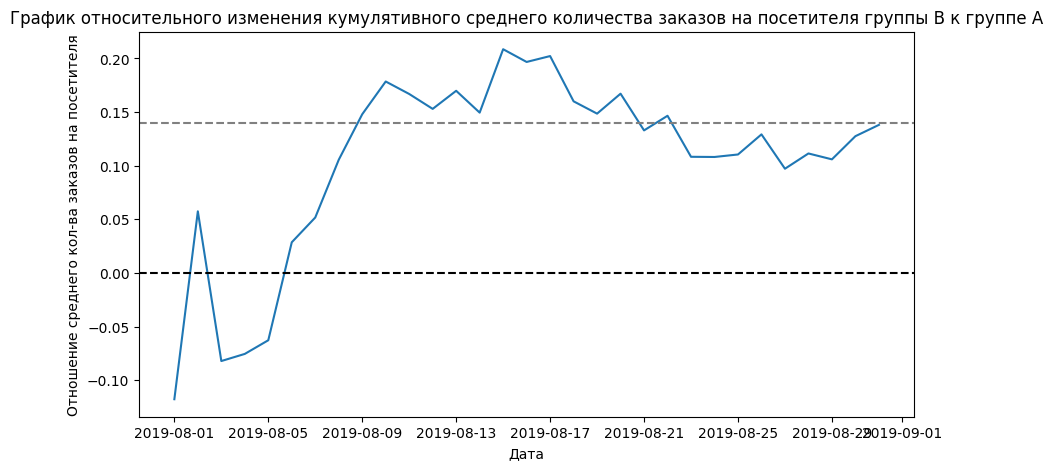

In [15]:
merged_сumulative_сonversions = (
    cumulative_data_a[['date','conversion']]
    .merge(cumulative_data_b[['date','conversion']], 
           left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
)
plt.figure(figsize=(10, 5))
plt.plot(
    merged_сumulative_сonversions['date'], merged_сumulative_сonversions['conversion_b']
    /merged_сumulative_сonversions['conversion_a']-1, 
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего кол-ва заказов на посетителя')
plt.show()

*Почти с самого начала теста группа B лидирует по метрике: в один момент среднее количество заказов на посетителя группы B было выше среднего количества заказов на посетителя группы А на 20% , затем зафиксировалась около прироста в 14% относительно группы A.*

#### Построение точечного графика количества заказов по пользователям, рассчет 95-ого и 99-ого перцентиля количества заказов на пользователя

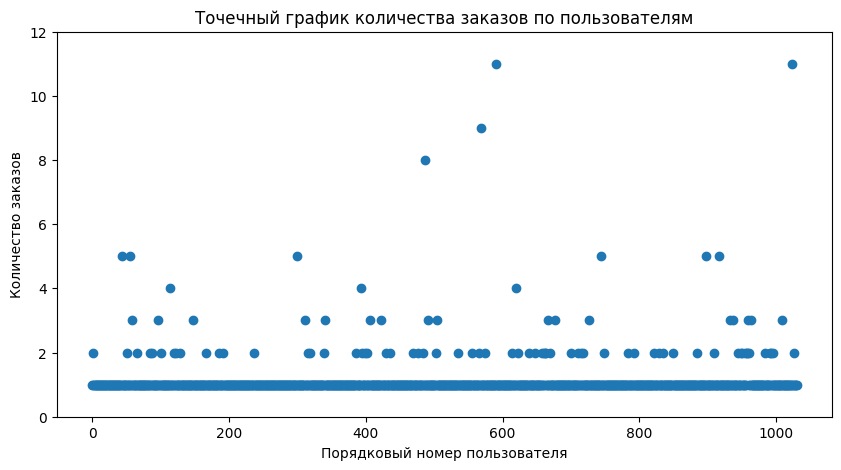

In [16]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'count'})
)
orders_by_users.columns = ['user_id', 'orders']

x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders_by_users['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество заказов')
plt.ylim(0, 12)
plt.show()

In [17]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

*Среди более чем 1000 покупателей, не более 5% пользователей совершали больше двух заказов и не более 1% пользователей — больше четырех заказов. Аномальными можно считать пользователей, совершивших более трех заказов.*

#### Построение точечного графика стоимостей заказов, рассчет 95-ого и 99-ого перцентиля стоимости заказов

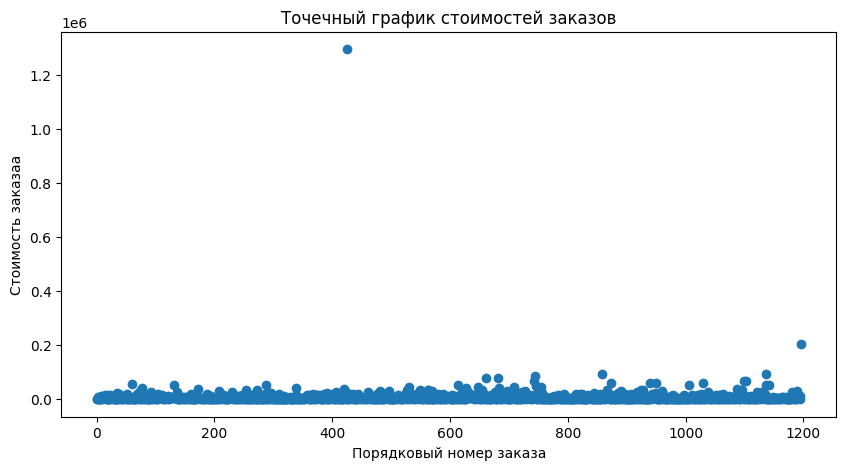

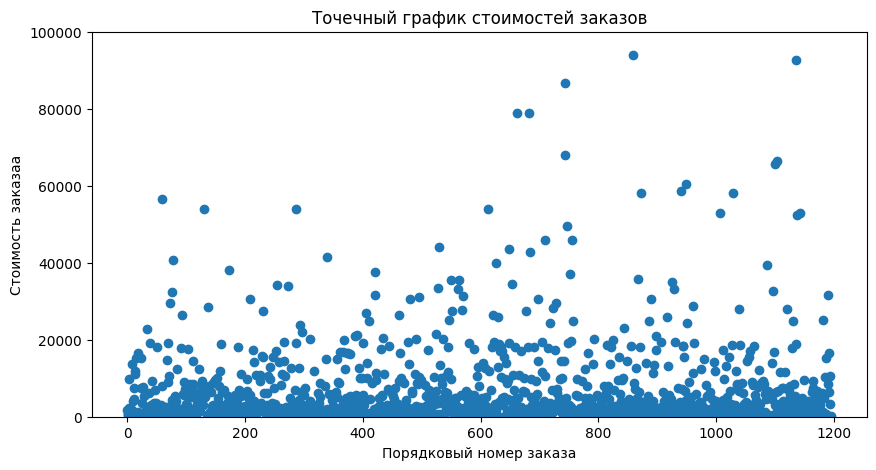

In [18]:
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказаа')

plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказаа')
plt.ylim(0, 100000)
plt.show()

In [19]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

*Из почти 1200 заказов, не более чем у 5% чек дороже 28000 и не более чем у 1% заказов — дороже 58233. Аномальными можно считать заказы дороже 40000.*

#### Рассчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [20]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
dt = (
    visitors_a_daily.merge(
        visitors_b_daily, left_on='date', right_on='date', how='left'
    ))
dt.head()

,date,visitors_per_date_a,visitors_per_date_b
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707


Нулевая гипотеза: различий в среднем количестве заказов между группами нет.

Альтернативная гипотеза: различия в среднем между группами есть.

In [21]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'count'})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'count'})
)
orders_by_users_b.columns = ['user_id', 'orders']

sample_a = pd.concat(
    [orders_by_users_a['orders'], 
     pd.Series(0, index=np.arange(dt['visitors_per_date_a'].sum() 
                                  - len(orders_by_users_a)), name='orders')],axis=0
)
sample_b = pd.concat(
    [orders_by_users_b['orders'], 
     pd.Series(0, index=np.arange(dt['visitors_per_date_b'].sum() 
                                  - len(orders_by_users_b)), name='orders')],axis=0)

print("P-value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("Прирост среднего числа заказов группы B относительно группы А: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.01679
Прирост среднего числа заказов группы B относительно группы А: 0.138


In [22]:
sample_a.sort_values()

8864     0
11991    0
11990    0
11989    0
11988    0
        ..
18       4
23       4
227      5
278      5
499      7
Name: orders, Length: 18736, dtype: int64

*P-value меньше 0.05, потому нулевую гипотезу отвергаем, хотя если бы уровень значимости был 0.01, нулевую гипотезу бы не отвергли. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.*

#### Рассчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет.

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [23]:
print('P-value: {0:.3f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                 orders[orders['group']=='B']['revenue'])[1])
     )
print('Относительные различия в среднем чеке между группами: {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()
            / orders[orders['group']=='A']['revenue'].mean() - 1)
     ) 

P-value: 0.729
Относительные различия в среднем чеке между группами: 0.259


*При анализе «сырых данных», p-value значительно больше 0.05, значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B на 26% выше среднего чека группы A.*

#### Рассчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем количестве заказов между группами нет.

Альтернативная гипотеза: различия в среднем между группами есть.

In [24]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 3]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 3]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 40000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(f'Количество аномальных пользователей: {abnormal_users.count()}')
abnormal_users.head()

Количество аномальных пользователей: 34


1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
dtype: int64

In [25]:
sample_a = pd.concat(
    [orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'], 
     pd.Series(0, index=np.arange(dt['visitors_per_date_a'].sum() 
                                  - len(orders_by_users_a)), name='orders')],axis=0
)
sample_b = pd.concat(
    [orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'], 
     pd.Series(0, index=np.arange(dt['visitors_per_date_b'].sum() 
                                  - len(orders_by_users_b)), name='orders')],axis=0)

print("P-value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("Прирост среднего числа заказов группы B относительно группы А: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.00931
Прирост среднего числа заказов группы B относительно группы А: 0.164


*P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «очищенных данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 16.4%.*

*P-value уменьшился относительно результатов анализа «сырых данных», теперь при уровне значимости 0.01, нулевую гипотезу бы все равно отвергли. Разница между сегментами увеличилась с 14% до 16%.*

#### Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами нет.

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [26]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительные различия в среднем чеке между группами: {0:.2f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.711
Относительные различия в среднем чеке между группами: 0.06


*При анализе «очищенных данных», p-value значительно больше 0.05, значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B всего на 6% выше среднего чека группы A.*

*P-value незначительно уменьшился относительно результатов анализа «сырых данных», зато разница между сегментами сократилась с 26% до 6%.*

При уровне статистической значимости 0.05, есть статистически значимое различие среднего количества заказов на посетителя между группами как по «сырым», так и по данным после фильтрации аномалий. Анализ «сырых данных» сообщает, что относительный прирост среднего группы B к конверсии группы A равен 13.8%, тогда как анализ «очищенных данных» сообщает, что относительный прирост среднего группы B к конверсии группы A равен 16.4%;

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При анализе «очищенных данных», разница между сегментами сократилась до 6%, тогда как при анализе «сырых данных» она составляла 26%;

График различия среднего количества заказов между группами сообщает, что результаты группы B зафиксировалась около прироста в 14% относительно группы A;

График различия среднего чека сильно зависит от аномально дорогих заказов, средний чек группы B выше среднего чека группы A приблизительно на 25%, различие постепенно снижается.

**Вывод:** *Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A, особенно такой его показатель как количество заказов на постетилеля — практически стопроцентная.* 